In [ ]:
import os
import shutil

# Set paths to writable location (working directory)
KAGGLE_WORKING_PATH = '/kaggle/working'

# Download datasets to the writable working directory
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia -p $KAGGLE_WORKING_PATH
!kaggle datasets download -d nitsanbenhanoch/pre-processed-xray-lungs-segmentation -p $KAGGLE_WORKING_PATH
!kaggle datasets download -d farhanhaikhan/unet-lung-segmentation-weights-for-chest-x-rays -p $KAGGLE_WORKING_PATH
!kaggle datasets download -d nitsanbenhanoch/lungs-xray-anomaly -p $KAGGLE_WORKING_PATH

# Unzip datasets into the writable working directory
!unzip $KAGGLE_WORKING_PATH/chest-xray-pneumonia.zip -d $KAGGLE_WORKING_PATH/chest-xray-pneumonia
!unzip $KAGGLE_WORKING_PATH/pre-processed-xray-lungs-segmentation.zip -d $KAGGLE_WORKING_PATH/pre-processed-xray-lungs-segmentation
!unzip $KAGGLE_WORKING_PATH/unet-lung-segmentation-weights-for-chest-x-rays.zip -d $KAGGLE_WORKING_PATH/unet-lung-segmentation-weights
!unzip $KAGGLE_WORKING_PATH/lungs-xray-anomaly.zip -d $KAGGLE_WORKING_PATH/lungs-xray-anomaly

print('All datasets and models have been downloaded and unzipped to the working directory.')


## Lungs X-Ray Anomaly-Detection

After **training on healthy lungs only**, we **identify pneumonia** in lungs x-ray.

In [ ]:
import os

# Suppress TensorFlow logging (1 = INFO, 2 = WARNING, 3 = ERROR)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
from keras.models import *
from keras.layers import *

import pandas as pd
import numpy as np
import cv2

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

## Let's meet our data

In [ ]:
classes = np.array(['NORMAL', 'PNEUMONIA'])

In [ ]:
# Updated base_path to the correct location within the Kaggle dataset
base_path = '/kaggle/working/chest-xray-pneumonia/chest_xray'

def img_paths(dirname, label):
    data = []
    subdir_path = os.path.join(base_path, dirname, label)

    # Check if the subdirectory exists before attempting to list its contents
    if os.path.exists(subdir_path):
        for filename in os.listdir(subdir_path):
            data.append({'img_path': os.path.join(subdir_path, filename)})
    else:
        print(f"Warning: Directory not found: {subdir_path}")  # Print a warning if the directory is not found

    return pd.DataFrame(data)

# dataframes for paths of original images
all_healthy_images_df = pd.concat(
    [
        img_paths('train', 'NORMAL'),
        img_paths('val', 'NORMAL')
    ],
    ignore_index=True,
)

test_healthy_df = img_paths('test', 'NORMAL')
test_pneumon_df = img_paths('test', 'PNEUMONIA')

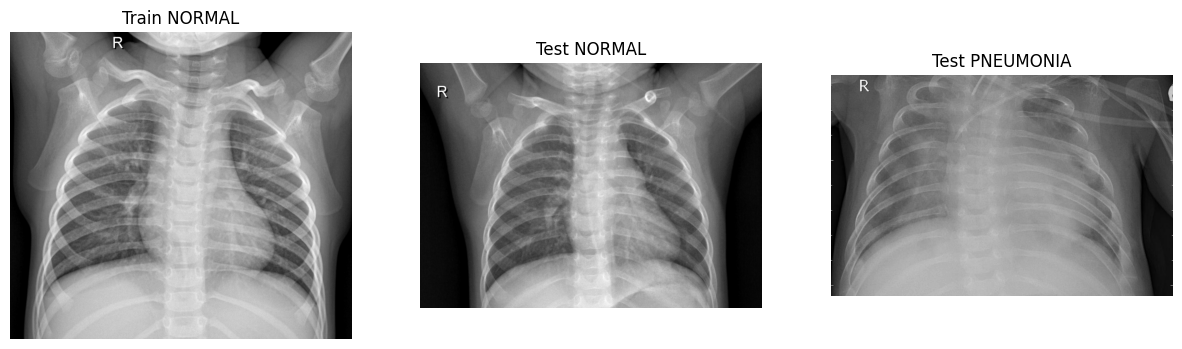

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

train_normal_img = cv2.imread(all_healthy_images_df.iloc[8]['img_path'], cv2.IMREAD_GRAYSCALE)
axes[0].imshow(train_normal_img, cmap='gray')
axes[0].set_title("Train NORMAL")
axes[0].axis('off')

test_normal_img = cv2.imread(test_healthy_df.iloc[101]['img_path'], cv2.IMREAD_GRAYSCALE)
axes[1].imshow(test_normal_img, cmap='gray')
axes[1].set_title("Test NORMAL")
axes[1].axis('off')

test_pneumonia_img = cv2.imread(test_pneumon_df.iloc[204]['img_path'], cv2.IMREAD_GRAYSCALE)
axes[2].imshow(test_pneumonia_img, cmap='gray')
axes[2].set_title("Test PNEUMONIA")
axes[2].axis('off')

plt.show()

In [ ]:
print(f"""
    train + val: {len(all_healthy_images_df)} NORMAL images

    test_healthy: {len(test_healthy_df)} NORMAL images

    test_pneumon: {len(test_pneumon_df)} PNEUMONIA images
""")


    train + val: 1349 NORMAL images

    test_healthy: 234 NORMAL images

    test_pneumon: 390 PNEUMONIA images



In [ ]:
print(test_pneumon_df.head())

                                            img_path
0  /kaggle/working/chest-xray-pneumonia/chest_xra...
1  /kaggle/working/chest-xray-pneumonia/chest_xra...
2  /kaggle/working/chest-xray-pneumonia/chest_xra...
3  /kaggle/working/chest-xray-pneumonia/chest_xra...
4  /kaggle/working/chest-xray-pneumonia/chest_xra...


**Preprocessing**

In [ ]:
def unet(input_size=(512,512,1)):
    inputs = Input(input_size)

    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    return Model(inputs=[inputs], outputs=[conv10])

The lungs segmentation U-Net works pretty well, but sometimes it leaves **small blobs
around the lungs; we remove them using cv2** classical image processing.

In [ ]:
def read_and_preprocess(segmentation_model, img_path):
    img_data = cv2.imread(img_path, 0)
    img_data = cv2.resize(img_data, (512, 512))

    prep_unet_input_img = img_data.reshape(1, 512, 512, 1)
    prep_unet_input_img = (prep_unet_input_img - 127.0) / 127.0

    with tf.device('/cpu:0'):
        segmentation = segmentation_model.predict(prep_unet_input_img, verbose=False)

    res = np.squeeze(segmentation)
    res = (res * 255 > 127).astype(np.int8)
    res = cv2.bitwise_and(img_data, img_data, mask=res)

    # the lungs segmentation model mostly works, but sometimes it leaves small blobs
    # around the lungs. we will remove them using classical cv2 image processing.
    return two_largest_contours(res) / np.float32(255)


def two_largest_contours(gray):
    _, binary = cv2.threshold(gray, 30, 255, cv2.THRESH_BINARY)

    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # find the two largest contours which should correspond to the lungs
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:2]

    mask = np.zeros_like(gray)
    cv2.drawContours(mask, contours, -1, (255), thickness=cv2.FILLED)

    return cv2.bitwise_and(gray, gray, mask=mask)

In [ ]:
"""
Runs the Lungs-Segmentation model on all images.

It takes ~45 mins to run on CPU,
And for some reason, we couldn't get it to run on GPU.

Therefore, we ran it once and downloaded a zip of the results.
"""

# from IPython.display import FileLink
# from tqdm import tqdm


# segmentation_model_weights_path = \
#     "/kaggle/input/unet-lung-segmentation-weights-for-chest-x-rays/cxr_reg_weights.best.hdf5"

# with tf.device('/cpu:0'):
#     segmentation_model = unet(input_size=(512,512,1))
#     segmentation_model.load_weights(segmentation_model_weights_path)


# !rm -rf pre-processed-train && mkdir pre-processed-train
# !rm -rf pre-processed-test-normal && mkdir pre-processed-test-normal
# !rm -rf pre-processed-test-pneumon && mkdir pre-processed-test-pneumon


# for img_path in tqdm(all_healthy_images_df['img_path']):
#     pre_processed_img = read_and_preprocess(segmentation_model, img_path)
#     img_name = os.path.basename(img_path)
#     assert cv2.imwrite(os.path.join('pre-processed-train', img_name), pre_processed_img)


# for img_path in tqdm(test_healthy_df['img_path']):
#     pre_processed_img = read_and_preprocess(segmentation_model, img_path)
#     img_name = os.path.basename(img_path)
#     assert cv2.imwrite(os.path.join('pre-processed-test-normal', img_name), pre_processed_img)


# for img_path in tqdm(test_pneumon_df['img_path']):
#     pre_processed_img = read_and_preprocess(segmentation_model, img_path)
#     img_name = os.path.basename(img_path)
#     assert cv2.imwrite(os.path.join('pre-processed-test-pneumon', img_name), pre_processed_img)


# !zip -r pre-processed.zip pre-processed-train pre-processed-test-normal pre-processed-test-pneumon

# FileLink(r'pre-processed.zip')

"\nRuns the Lungs-Segmentation model on all images.\n\nIt takes ~45 mins to run on CPU,\nAnd for some reason, we couldn't get it to run on GPU.\n\nTherefore, we ran it once and downloaded a zip of the results.\n"

In [ ]:
# I downloaded 'pre-processed.zip' and loaded it as a dataset, to not lose it on session restart

preprocessed_base_path = '/kaggle/working/pre-processed-xray-lungs-segmentation/'

---
## Make Train + Val Datasets


We concat each original image alongside an image containing only the lungs.

In [ ]:

BATCH_SIZE = 32
IMAGE_DIMENSIONS = (224, 224)
CONCATENATED_IMAGE_DIMENSIONS = (IMAGE_DIMENSIONS[0], IMAGE_DIMENSIONS[1] * 2)
# Function definitions remain unchanged
def load_one_img(img_path, augment=False):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, channels=1, expand_animations=False)
    img = tf.image.resize(img, IMAGE_DIMENSIONS)

    if augment:
        img = tf.image.random_brightness(img, max_delta=0.1)
        img = tf.image.random_contrast(img, lower=0.8, upper=1.2)

    return img / 255.0

def load_pair_images(original_img_path, preprocessed_dirname, augment=False):
    original_img = load_one_img(original_img_path, augment)
    preprocessed_img_path = tf.strings.join([
        preprocessed_base_path,
        preprocessed_dirname,
        tf.strings.split(original_img_path, os.sep)[-1]
    ], separator=os.sep)
    preprocessed_img = load_one_img(preprocessed_img_path)
    return tf.concat([original_img, preprocessed_img], axis=1)

def create_dataset(original_df, preprocessed_dirname, shuffle=False, repeat=False, augment=False):
    original_paths_dataset = tf.data.Dataset.from_tensor_slices(original_df['img_path'].values)

    def load_pair_as_return_pair_pair(original_path):
        pair = load_pair_images(original_path, preprocessed_dirname, augment=augment)
        return pair, pair  # Autoencoder, so y is x

    images_dataset = original_paths_dataset.map(
        load_pair_as_return_pair_pair,
        num_parallel_calls=tf.data.AUTOTUNE
    )

    if shuffle:
        images_dataset = images_dataset.shuffle(buffer_size=len(original_df))

    if repeat:
        images_dataset = images_dataset.repeat()

    return images_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


    Our new datasets are made of images like this one:



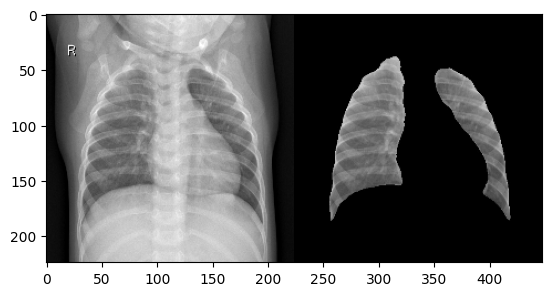

In [ ]:
# Display a sample concatenated image
sample_concatenated_img = load_pair_images(
    os.path.join(base_path, 'train/NORMAL/IM-0122-0001.jpeg'),
    'pre-processed-train',
    augment=False
)

plt.imshow(sample_concatenated_img, cmap='gray')

print(f"""
    Our new datasets are made of images like this one:
""")

In [ ]:

# Splitting your dataset
TRAIN_RATIO = 0.80  # training ratio
train_df, val_df = train_test_split(
    all_healthy_images_df,
    train_size=TRAIN_RATIO,
    random_state=123,
)

# Select 25 random images from the training and validation datasets
train_sample_df = train_df.sample(n=25, random_state=42)  # Randomly select 25 images
val_sample_df = val_df.sample(n=25, random_state=42)  # Randomly select 25 images

# Create datasets using the sampled DataFrames
train_dataset = create_dataset(
    train_sample_df, 'pre-processed-train',
    shuffle=True, repeat=True, augment=True
)

val_dataset = create_dataset(
    val_sample_df, 'pre-processed-train',
    repeat=True
)

In [ ]:
def format_stats_row(name, df, used_in_training):
    return '%13s | %4d | %s' % (name, len(df), '✔️' if used_in_training else '✗')

print('   split name | size | used in training ')
print('--------------+------+------------------')
print(format_stats_row('train_healthy', train_df, used_in_training=True))
print(format_stats_row('val_healthy',   val_df,   used_in_training=True))
print(format_stats_row('test_healthy',  test_healthy_df,  used_in_training=False))
print(format_stats_row('test_pneumon',  test_pneumon_df,  used_in_training=False))

   split name | size | used in training 
--------------+------+------------------
train_healthy | 1079 | ✔️
  val_healthy |  270 | ✔️
 test_healthy |  234 | ✗
 test_pneumon |  390 | ✗


---
## Our Model

In [ ]:
from tensorflow.keras.utils import register_keras_serializable

@register_keras_serializable()
class GrayscaleToRGB(Layer):
    def __init__(self, **kwargs):
        super(GrayscaleToRGB, self).__init__(**kwargs)

    def call(self, inputs):
        # repeat last channel to transform grayscale into "color"
        return tf.tile(inputs, [1, 1, 1, 3])

In [ ]:
from keras.applications import VGG16

def make_autoencoder(input_shape):
    vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(*input_shape, 3))

    autoencoder = Sequential(name='lungs_anomaly_ae')

    autoencoder.add(GrayscaleToRGB(name='grayscale_to_rgb'))

    # transfer VGG16's first layers (excluding its input)
    for layer in vgg16.layers[1: 4]:
        layer.name = f'vgg16_{layer.name}'
        layer.trainable = False
        autoencoder.add(layer)

    # a very wide "bottle-neck"
    autoencoder.add(Conv2D(32, (3, 3), padding='same', activation='relu', name="bottle_neck"))

    autoencoder.add(UpSampling2D(size=(2, 2), name='up_sampling'))
    autoencoder.add(Conv2DTranspose(64, (3, 3), padding='same', activation='relu', name='conv_t1'))
    autoencoder.add(Conv2DTranspose(64, (3, 3), padding='same', activation='relu', name='conv_t2'))

    autoencoder.add(Conv2DTranspose(1, (3, 3), padding='same', activation='sigmoid', name='output'))

    # forward something thru the model to init it
    x = np.random.random([1, *input_shape, 1])
    autoencoder(x)

    return autoencoder

In [ ]:

autoencoder = make_autoencoder(CONCATENATED_IMAGE_DIMENSIONS)

autoencoder.summary()


bottle_neck_shape = autoencoder.get_layer('bottle_neck').output.shape
print(f'''
"Bottle-Neck" Size: {" x ".join(map(str, bottle_neck_shape))} == {np.product(bottle_neck_shape):,}
''')

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "lungs_anomaly_ae"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ grayscale_to_rgb (GrayscaleToRGB)    │ (1, 224, 448, 3)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg16_block1_conv1 (Conv2D)          │ (1, 224, 448, 64)           │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg16_block1_conv2 (Conv2D)          │ (1, 224, 448, 64)           │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg16_block1_pool (MaxPooling2D)     │ (1, 112, 224, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bottle_neck (Conv2D)                 │ (1, 112, 224, 32)           │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling (UpSampling2D)           │ (1, 224, 448, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_t1 (Conv2DTranspose)            │ (1, 224, 448, 64)           │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_t2 (Conv2DTranspose)            │ (1, 224, 448, 64)           │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Conv2DTranspose)             │ (1, 224, 448, 1)            │             577 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 113,185 (442.13 KB)

 Trainable params: 74,465 (290.88 KB)

 Non-trainable params: 38,720 (151.25 KB)


"Bottle-Neck" Size: 1 x 112 x 224 x 32 == 802,816



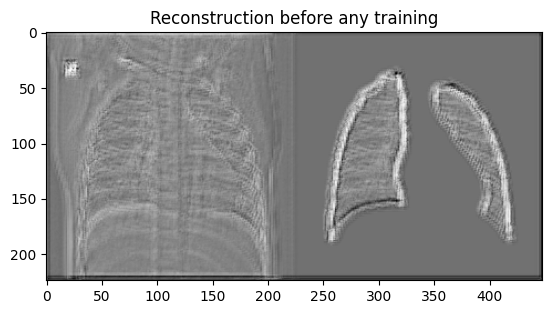

In [ ]:
sample_concatenated_img = load_pair_images(
    os.path.join(base_path, 'train/NORMAL/IM-0122-0001.jpeg'),
    'pre-processed-train',
    augment=False
)

sample_concatenated_img__as_batch = \
    sample_concatenated_img.numpy().reshape((1, *CONCATENATED_IMAGE_DIMENSIONS, 1))

plt.imshow(
    autoencoder.predict(sample_concatenated_img__as_batch, verbose=False).squeeze(),
    cmap='gray'
)
plt.title(f"Reconstruction before any training")
plt.show()

---
## Loss Function

We split the images in half, and measure the reconstruction error of each (full_xray, just_lungs) independently, using SSIM. We combine the two errors using a weighted sum.

```0.25 * ssim_full_xray + 0.75 * ssim_just_lungs```

In [ ]:
@register_keras_serializable()
def weighted_loss(y_true, y_pred, batch_average=True):
    # split each pair into two halves
    img1_a, img1_b = tf.split(y_true, num_or_size_splits=2, axis=2)
    img2_a, img2_b = tf.split(y_pred, num_or_size_splits=2, axis=2)

    # compare left-left and right-right
    ssim_a = tf.image.ssim(img1_a, img2_a, max_val=1.0)
    ssim_b = tf.image.ssim(img1_b, img2_b, max_val=1.0)

    if batch_average:
        ssim_a = tf.reduce_mean(ssim_a)
        ssim_b = tf.reduce_mean(ssim_b)

    # right side (lungs-only) is worth more
    loss = 0.25 * ssim_a + 0.75 * ssim_b

    # lower values should indicate better performance
    return 1 - loss

In [ ]:
if tf.config.list_physical_devices('GPU'):
    print("Using GPU :)")
else:
    print("No GPU :/")

Using GPU :)


---
## Stats

We measure (and log) the model's ability to distinguish betwen normal and pneumonia images, as training progresses.
Since train and val only contain normal images, this measurement is performed over the test-set.


These stats are not used to guide the training process in any way; we only use them *after* training's over, to draw analytics.

In [ ]:
def imagewise_loss(autoencoder, original_df, preprocessed_dirname):
    data = create_dataset(original_df, preprocessed_dirname)
    losses = []
    for x, x in data:
        predictions = autoencoder.predict(x, verbose=False)
        batch_losses = weighted_loss(x, predictions, batch_average=False)
        losses.append(batch_losses)
    return np.hstack(losses)


"""
Define NORMAL reconstruction loss range as:

    val_mean_loss ± val_stddev_loss
"""

def count_anomalies(losses_array, val_mean_loss, val_stddev_loss):
    above = np.sum(losses_array > val_mean_loss + val_stddev_loss)
    below = np.sum(losses_array < val_mean_loss - val_stddev_loss)
    return above + below


def calc_stats(ae):
    val_losses            = imagewise_loss(ae, val_df,          'pre-processed-train')
    test_NORMAL_losses    = imagewise_loss(ae, test_healthy_df, 'pre-processed-test-normal')
    test_PNEUMONIA_losses = imagewise_loss(ae, test_pneumon_df, 'pre-processed-test-pneumon')

    # alternatively, for a slower but more precise baseline, use all healthy images:
    # val_losses            = imagewise_loss(ae, all_healthy_images_df, 'pre-processed-train')

    val_mean_loss   = np.mean(val_losses)
    val_stddev_loss = np.std (val_losses)

    test_NORMAL_mean_loss   = np.mean(test_NORMAL_losses)
    test_NORMAL_stddev_loss = np.std (test_NORMAL_losses)

    test_PNEUMONIA_mean_loss   = np.mean(test_PNEUMONIA_losses)
    test_PNEUMONIA_stddev_loss = np.std (test_PNEUMONIA_losses)

    diff = (test_NORMAL_mean_loss - test_NORMAL_stddev_loss) - \
           (test_PNEUMONIA_mean_loss + test_PNEUMONIA_stddev_loss)

    TP = count_anomalies(test_PNEUMONIA_losses, val_mean_loss, val_stddev_loss)
    FP = count_anomalies(test_NORMAL_losses, val_mean_loss, val_stddev_loss)

    FN = len(test_pneumon_df) - TP
    TN = len(test_healthy_df) - FP

    Precision = TP / (TP + FP)
    Recall = TP / (TP + FN)

    F1_Score = 2 * (Precision * Recall) / (Precision + Recall)

    # Calculate Accuracy
    Accuracy = (TP + TN) / (TP + FP + FN + TN)

    # Validation Accuracy
    val_TP = count_anomalies(val_losses[val_df['label'] == 1], val_mean_loss, val_stddev_loss)
    val_FP = count_anomalies(val_losses[val_df['label'] == 0], val_mean_loss, val_stddev_loss)

    val_FN = np.sum(val_df['label'] == 1) - val_TP
    val_TN = np.sum(val_df['label'] == 0) - val_FP

    Val_Accuracy = (val_TP + val_TN) / len(val_df)

    return {
        'Val_Mean_Loss': val_mean_loss,
        'Val_StdDev_Loss': val_stddev_loss,
        'Test_NORMAL_Mean_Loss': test_NORMAL_mean_loss,
        'Test_NORMAL_StdDev_Loss': test_NORMAL_stddev_loss,
        'Test_PNEUMONIA_Mean_Loss': test_PNEUMONIA_mean_loss,
        'Test_PNEUMONIA_StdDev_Loss': test_PNEUMONIA_stddev_loss,
        'Gap': diff,
        'TP': TP,
        'FP': FP,
        'FN': FN,
        'TN': TN,
        'Precision': Precision,
        'Recall': Recall,
        'F1_Score': F1_Score,
        'Accuracy': Accuracy,
        'Val_Accuracy': Val_Accuracy
    }


def pretty_print_stats(entry):
    if 'Epoch' in entry:
        print(f"\n    Epoch: {entry['Epoch']}")

    print(f"""
    Val. Loss on NORMAL images:
        Mean: {entry['Val_Mean_Loss']:.5f}
        Std.: {entry['Val_StdDev_Loss']:.5f}

    Test Loss on NORMAL images:
        Mean: {entry['Test_NORMAL_Mean_Loss']:.5f}
        Std.: {entry['Test_NORMAL_StdDev_Loss']:.5f}

    Test Loss on PNEUMONIA images:
        Mean: {entry['Test_PNEUMONIA_Mean_Loss']:.5f}
        Std.: {entry['Test_PNEUMONIA_StdDev_Loss']:.5f}

    [test_loss ± 1 std. differs by {entry['Gap']:.5f} between the classes]

    TP = {entry['TP']}\tFP = {entry['FP']}

    FN = {entry['FN']}\tTN = {entry['TN']}

    Precision: {entry['Precision']:.5f}
    Recall:    {entry['Recall']:.5f}
    F1 Score:  {entry['F1_Score']:.5f}
    Accuracy:  {entry['Accuracy']:.5f}
    Val. Accuracy: {entry['Val_Accuracy']:.5f}
    """)


In [ ]:
from keras.callbacks import *


epoch_to_stats = [
    5, 10, 15, 20, 25, 30, 35, 40, 50, 60,
    70, 80, 90, 100, 125, 150, 175, 200, 250,
]

class StatsCallback(Callback):
    def __init__(self):
        super().__init__()
        self.best_val_loss = np.inf
        self.stats_entries = []

    def on_epoch_end(self, epoch, logs=None):
        epoch += 1 # 0-based count -> 1-based count

        current_val_loss = logs.get('val_loss')
        loss_improved = current_val_loss < self.best_val_loss
        if loss_improved:
            self.best_val_loss = current_val_loss
            autoencoder.save_weights('tmp-best.weights.h5')
            ae = autoencoder

        if epoch not in epoch_to_stats:
            return

        if not loss_improved:
            ae = make_autoencoder(CONCATENATED_IMAGE_DIMENSIONS)
            ae.load_weights('tmp-best.weights.h5')

        entry = calc_stats(ae)
        entry['Epoch'] = epoch

        self.stats_entries.append(entry)
        pretty_print_stats(entry)


stats_callback = StatsCallback()

---
## Training

In [ ]:
from keras.optimizers import Adam

autoencoder.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=weighted_loss,
)

In [ ]:
""" Callbacks """
model_checkpoint = ModelCheckpoint(
    'ae_checkpoint_epoch_{epoch:03d}.keras',
    save_best_only=False,
    save_weights_only=False,
)

reduce_lr_on_plateau = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=10,
    verbose=True,
    mode='min',
    min_delta=1e-4,
    cooldown=2,
    min_lr=1e-6,
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=25,
    verbose=True,
    restore_best_weights=True,
)

In [ ]:
history = autoencoder.fit(
    train_dataset,
    steps_per_epoch=int(np.ceil(len(train_sample_df) / BATCH_SIZE)),  # Adjusted for 25 images
    validation_data=val_dataset,
    validation_steps=int(np.ceil(len(val_sample_df) / BATCH_SIZE)),  # Adjusted for 25 images
    epochs=200,
    callbacks=[
        model_checkpoint,
        reduce_lr_on_plateau,
        early_stopping,
    ],
)

Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 46s 46s/step - loss: 0.8636 - val_loss: 0.8421 - learning_rate: 1.0000e-04
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 673ms/step - loss: 0.8369 - val_loss: 0.8208 - learning_rate: 1.0000e-04
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 857ms/step - loss: 0.8179 - val_loss: 0.7978 - learning_rate: 1.0000e-04
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 826ms/step - loss: 0.7978 - val_loss: 0.7848 - learning_rate: 1.0000e-04
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 914ms/step - loss: 0.7841 - val_loss: 0.7742 - learning_rate: 1.0000e-04
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 871ms/step - loss: 0.7692 - val_loss: 0.7639 - learning_rate: 1.0000e-04
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 861ms/step - loss: 0.7536 - val_loss: 0.7533 - learning_rate: 1.0000e-04
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 963ms/step - loss: 0.7491 - val_loss: 0.7492 - learning_rate: 1.0000e-04
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 852ms/step - loss: 0.7420 - val_loss: 0.7457 - learning_r

In [ ]:
import tensorflow as tf

# Specify the path to your saved model
model_path = '/alldata2.keras'  # Adjust the path as needed

# Load the model
model = tf.keras.models.load_model(model_path)

# Verify the model
model.summary()  # Optional: to see the model architecture


Model: "lungs_anomaly_ae"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ grayscale_to_rgb (GrayscaleToRGB)    │ (1, 224, 448, 3)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg16_block1_conv1 (Conv2D)          │ (1, 224, 448, 64)           │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg16_block1_conv2 (Conv2D)          │ (1, 224, 448, 64)           │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg16_block1_pool (MaxPooling2D)     │ (1, 112, 224, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bottle_neck (Conv2D)                 │ (1, 112, 224, 32)           │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling (UpSampling2D)           │ (1, 224, 448, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_t1 (Conv2DTranspose)            │ (1, 224, 448, 64)           │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_t2 (Conv2DTranspose)            │ (1, 224, 448, 64)           │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Conv2DTranspose)             │ (1, 224, 448, 1)            │             577 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 262,117 (1023.90 KB)

 Trainable params: 74,465 (290.88 KB)

 Non-trainable params: 38,720 (151.25 KB)

 Optimizer params: 148,932 (581.77 KB)

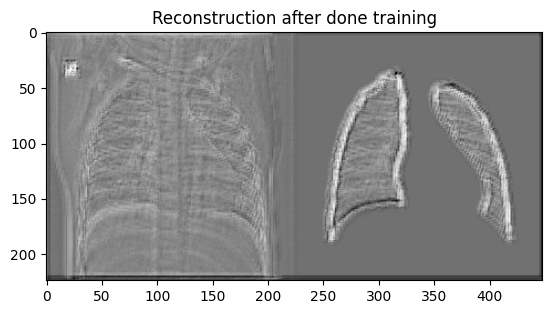

In [ ]:
sample_concatenated_img = load_pair_images(
    os.path.join(base_path, 'train/NORMAL/IM-0122-0001.jpeg'),
    'pre-processed-train',
    augment=False
)

sample_concatenated_img__as_batch = \
    sample_concatenated_img.numpy().reshape((1, *CONCATENATED_IMAGE_DIMENSIONS, 1))

plt.imshow(
    autoencoder.predict(sample_concatenated_img__as_batch, verbose=False).squeeze(),
    cmap='gray'
)
plt.title(f"Reconstruction after done training")
plt.show()

In [ ]:
from IPython.display import FileLink

autoencoder.save('alldata2.keras')
FileLink('alldata2.keras')

/content/alldata2.keras

## Final Anomaly Detection Accuracy

---


In [ ]:
# Given values
TP = 318
FP = 138
FN = 72
TN = 96

# Calculate total samples
total = TP + TN + FP + FN

# Calculate accuracy
accuracy = (TP + TN) / total

# Convert to percentage
accuracy_percentage = accuracy * 100

# Print accuracy
print(f"Accuracy: {accuracy:.4f} ({accuracy_percentage:.2f}%)")


Accuracy: 0.6635 (66.35%)


# **Grad-Cam**

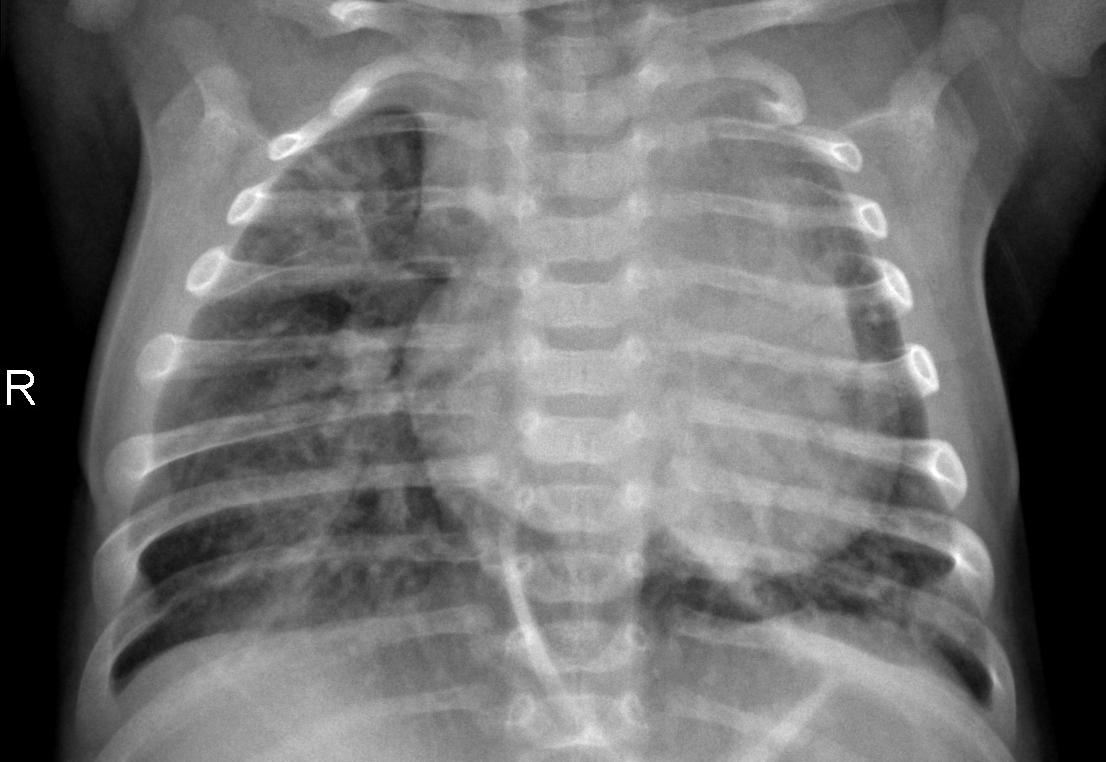

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
35363/35363 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Predicted class: [('n04557648', 'water_bottle', 0.46382362)]


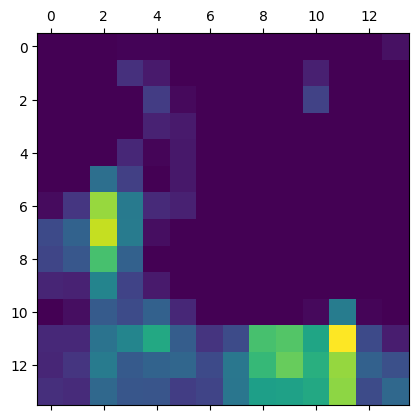

In [ ]:
from IPython.display import Image, display
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import keras
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions

# Define the correct last conv layer name for VGG16
last_conv_layer_name = "block5_conv3"

# The local path to our target image
img_path = "/kaggle/working/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/person100_bacteria_475.jpeg"

display(Image(img_path))

def get_img_array(img_path, size):
    # `img` is a PIL image
    img = keras.utils.load_img(img_path, target_size=size)
    array = keras.utils.img_to_array(img)
    # Add a dimension to transform the array into a "batch"
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # Create a model that maps the input image to the activations of the last conv layer and the output predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Compute the gradient of the top predicted class for our input image for the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # Compute the gradient of the class score w.r.t the output feature map
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # Pool the gradients across all the output feature maps
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Weigh the output feature map by the pooled gradients
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purposes, normalize the heatmap between 0 and 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Preparing the image
img_size = (224, 224)
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# Load the VGG16 model with ImageNet weights
model = VGG16(weights='imagenet', include_top=True, input_shape=(*img_size, 3))

# Make predictions
preds = model.predict(img_array)
print("Predicted class:", decode_predictions(preds, top=1)[0])

# Generate the class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Visualization of the heatmap
plt.matshow(heatmap)
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step
Predicted of image: [('n04557648', 'water_bottle', 0.46382362)]


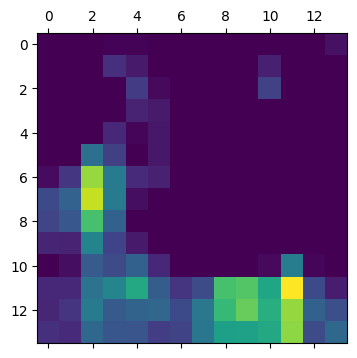

In [ ]:
## Preparing the image
img_size = (224, 224) # Change image size to (224, 224) for VGG16
img_array = preprocess_input(get_img_array(img_path, size=img_size))

## Making the model with imagenet dataset
# Define input_shape based on img_size
# Include the top classification layer for decode_predictions to work
model = VGG16(weights='imagenet', include_top=True, input_shape=(*img_size, 3))

## You don't need this line as include_top=True adds the softmax layer
# model.layers[-1].activation = None

preds = model.predict(img_array)
print("Predicted of image:", decode_predictions(preds, top=1)[0])

## Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

plt.figure(figsize=(4, 4))  # Adjust the figsize to make it smaller
plt.matshow(heatmap, fignum=1)  # Use fignum=1 to plot in the same figure as plt.figure()
plt.show()

<ipython-input-28-694cda8860d5>:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = mpl.cm.get_cmap("jet")


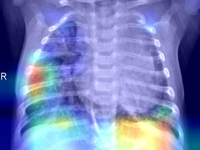

In [ ]:
import matplotlib.pyplot as mpl
from tensorflow.keras.utils import load_img, img_to_array, array_to_img
from PIL import Image
import numpy as np

def save_and_display_gradcam(img_path, heatmap, cam_path="save_cam_image.jpg", alpha=0.5, display_size=(200, 200)):
    ## Load the original image
    img = load_img(img_path)
    img = img_to_array(img)

    ## Normalize the image (optional)
    img = (img - img.min()) / (img.max() - img.min()) * 255.0

    ## Rescale heatmap to range 0-255
    heatmap = np.uint8(255 * heatmap)

    ## Resize heatmap to match image size
    jet = mpl.cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]  # RGB colors
    jet_heatmap = jet_colors[heatmap]

    ## Ensure both the heatmap and original image use the same resizing method
    heatmap_img = array_to_img(jet_heatmap)  # convert to image
    heatmap_img = heatmap_img.resize((img.shape[1], img.shape[0]), Image.Resampling.BILINEAR)  # resize to original image size using Resampling.BILINEAR
    heatmap_img = img_to_array(heatmap_img)  # back to array

    ## Overlay heatmap and original image
    superimposed_img = heatmap_img * alpha + img  # blend heatmap with the image
    superimposed_img = np.clip(superimposed_img, 0, 255)  # ensure pixel values are valid
    superimposed_img = array_to_img(superimposed_img)  # convert to image

    ## Save the final image
    superimposed_img.save(cam_path)

    ## Display Grad-CAM result resized to smaller size
    img_to_display = Image.open(cam_path).resize(display_size, Image.Resampling.LANCZOS)  # resize for display using Resampling.LANCZOS (or Resampling.BILINEAR)
    display(img_to_display)  # display the resized image

# Call the function to save and display the Grad-CAM result
save_and_display_gradcam(img_path, heatmap, display_size=(200, 150))  # Adjust size for display here

In [ ]:
# Step 1: Get model's prediction confidence
preds = model.predict(img_array)
prediction_confidence = preds[0][np.argmax(preds)]  # The confidence for the predicted class

# Step 2: Calculate mean activation intensity of Grad-CAM heatmap
mean_heatmap_activation = np.mean(heatmap)

# Step 3: Calculate Grad-CAM confidence score
gradcam_confidence_score = prediction_confidence * mean_heatmap_activation

print(f"Model Prediction Confidence: {prediction_confidence}")
print(f"Mean Heatmap Activation: {mean_heatmap_activation}")
print(f"Grad-CAM Confidence Score: {gradcam_confidence_score}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Model Prediction Confidence: 0.4638236165046692
Mean Heatmap Activation: 0.13053743541240692
Grad-CAM Confidence Score: 0.06054634600877762


# **LIME**

In [ ]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 6.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=b08dcb7b0e916b735e7b034abc2b4f4a86b966ee83559842e4e75ebd2224a21e
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [ ]:
import os
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.utils import load_img, img_to_array
import numpy as np

# Define VAE Encoder
latent_dim = 64  # Adjust latent dimension based on your requirements

class VAE(tf.keras.Model):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.encoder = tf.keras.Sequential([
            layers.InputLayer(input_shape=(224, 448, 1)),  # Update input shape to match your dataset
            layers.Conv2D(32, 3, strides=2, activation='relu'),
            layers.Conv2D(64, 3, strides=2, activation='relu'),
            layers.Flatten(),
            layers.Dense(latent_dim + latent_dim),  # Latent mean and variance
        ])
        self.decoder = tf.keras.Sequential([
            layers.InputLayer(input_shape=(latent_dim,)),
            layers.Dense(units=56 * 112 * 64, activation='relu'),  # Adjust units to match new input shape
            layers.Reshape(target_shape=(56, 112, 64)),  # Adjust reshape target shape
            layers.Conv2DTranspose(64, 3, strides=2, padding='same', activation='relu'),
            layers.Conv2DTranspose(32, 3, strides=2, padding='same', activation='relu'),
            layers.Conv2DTranspose(1, 3, strides=1, padding='same'),  # Change output channels to 1
        ])

    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar

    def decode(self, z, apply_sigmoid=False):
        logits = self.decoder(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=tf.shape(mean))
        return eps * tf.exp(logvar * .5) + mean

    def call(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterize(mean, logvar)
        return self.decode(z)

# Initialize VAE
vae = VAE(latent_dim)

def vae_loss(x, x_decoded_mean):
    # Get mean and logvar from the encoder
    mean, logvar = vae.encode(x)

    # Clip mean and logvar to prevent inf values
    mean = tf.clip_by_value(mean, -1e6, 1e6)
    logvar = tf.clip_by_value(logvar, -1e6, 1e6)

    # Reconstruction loss (e.g., MSE)
    reconstruction_loss = tf.reduce_mean(tf.square(x - x_decoded_mean))

    # KL divergence loss
    kl_loss = -0.5 * tf.reduce_mean(1 + logvar - tf.square(mean) - tf.exp(logvar))

    # Total loss - return a scalar value
    total_loss = tf.reduce_mean(reconstruction_loss + kl_loss)
    return total_loss


def load_and_preprocess_image(image_path):
    try:
        img = load_img(image_path, target_size=(224, 448), color_mode='grayscale')
        img_array = img_to_array(img)
        img_array = img_array / 255.0
        if img_array.shape[-1] != 1:  # Ensure the last dimension is 1
            img_array = np.expand_dims(img_array, axis=-1)  # Add channel dimension
        return img_array
    except (FileNotFoundError, OSError, ValueError) as e:
        print(f"Error loading image {image_path}: {e}")
        return None

# Load lung-segmented images from the specified path
lung_mask_segmented_path = '/kaggle/working/pre-processed-xray-lungs-segmentation/pre-processed-test-pneumon/'

train_data = []
for image_file in os.listdir(lung_mask_segmented_path):
    image_path = os.path.join(lung_mask_segmented_path, image_file)
    img_array = load_and_preprocess_image(image_path)
    if img_array is not None:  # Filter out None values
        train_data.append(img_array)

train_data = np.array(train_data)  # Convert to NumPy array after filtering
train_data = np.nan_to_num(train_data)

# Compile and train the VAE model
vae.compile(optimizer=tf.keras.optimizers.Adam(), loss=vae_loss)
vae.fit(train_data, train_data, epochs=10)
save_path = 'vae_model.keras'  # or use 'vae_model/' for a directory format

# Save the entire VAE model
vae.save(save_path)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 37s 781ms/step - loss: 0.4225
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 12s 135ms/step - loss: 0.0317
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - loss: 0.0239
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - loss: 0.0215
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - loss: 0.0217
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - loss: 0.0207
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - loss: 0.0206
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - loss: 0.0200
Epoch 9/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - loss: 0.0206
Epoch 10/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - loss: 0.0202


In [ ]:
save_path = 'vae_model.keras'  # or use 'vae_model/' for a directory format

# Save the entire VAE model
vae.save(save_path)
print(f"Model saved at: {os.path.abspath(save_path)}")

Model saved at: /content/vae_model.keras


In [ ]:
from IPython.display import FileLink

vae.save('vae_model.keras')
FileLink('vae_model.keras')

/content/vae_model.keras

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
vae.save('/content/drive/MyDrive/vae_model.keras')

  0%|          | 0/300 [00:00<?, ?it/s]

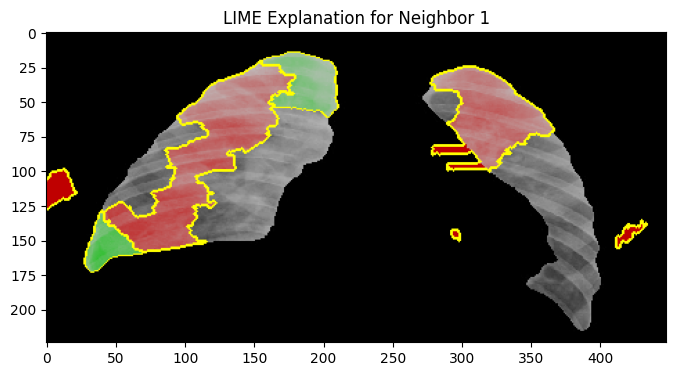

  0%|          | 0/300 [00:00<?, ?it/s]

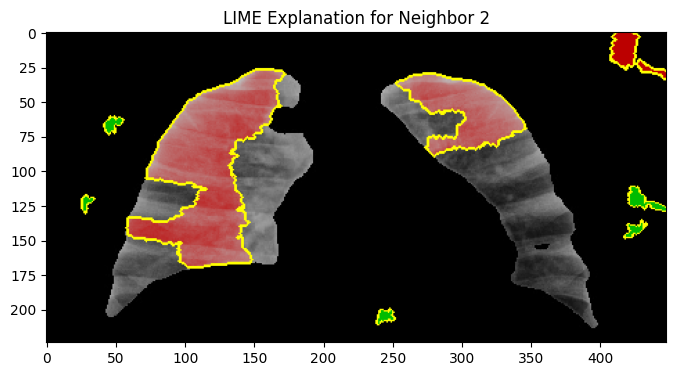

  0%|          | 0/300 [00:00<?, ?it/s]

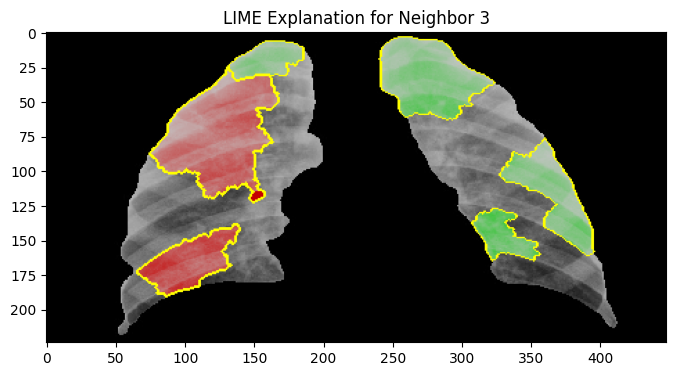

  0%|          | 0/300 [00:00<?, ?it/s]

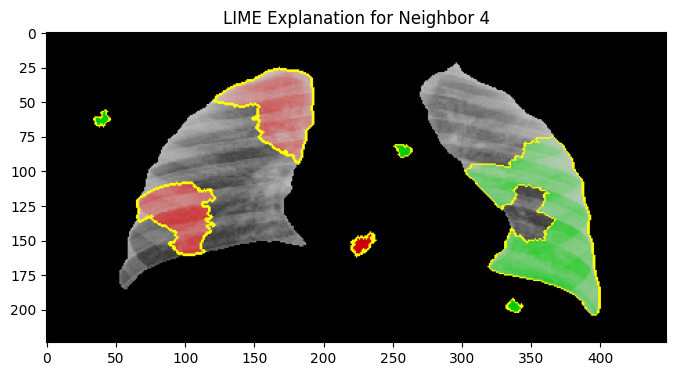

  0%|          | 0/300 [00:00<?, ?it/s]

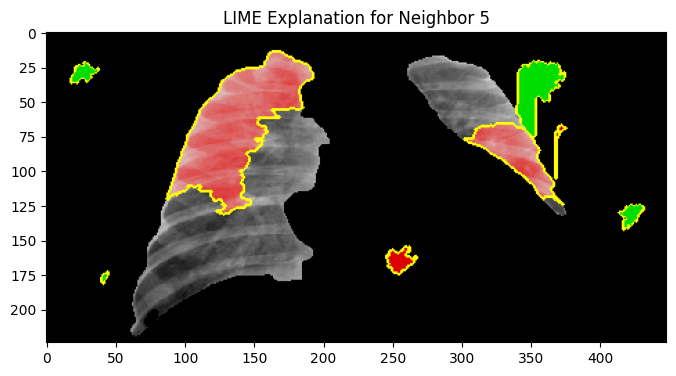

In [ ]:
from lime import lime_image
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries
from tensorflow.keras.utils import img_to_array

def vae_prediction_function(images):
    """
    Prediction function for LIME.

    Args:
        images: A list of perturbed images.

    Returns:
        Predictions for the perturbed images.
    """
    # Convert the list of images to a NumPy array
    images = np.array(images)

    # If the input is a single image, add a batch dimension
    if len(images.shape) == 3:
        images = np.expand_dims(images, axis=0)

    # Ensure images are grayscale (single channel)
    # by taking the mean across channels if needed
    if images.shape[-1] == 3:
        images = np.mean(images, axis=-1, keepdims=True)

    # Normalize to [0, 1] if not already
    if images.max() > 1:
        images = images / 255.0

    # Get reconstructed images from the VAE
    reconstructed_images = vae.decode(vae.reparameterize(*vae.encode(images)))

    # Calculate a single prediction value for each image (e.g., mean squared error)
    predictions = np.mean((images - reconstructed_images.numpy())**2, axis=(1, 2, 3))

    return predictions.reshape(-1, 1)  # Reshape to (num_samples, 1)


# Initialize LIME image explainer
explainer = lime_image.LimeImageExplainer()

# Load and preprocess the test images from your lung mask segmented dataset
# Example path: '/kaggle/working/pre-processed-xray-lungs-segmentation/pre-processed-test-pneumon/'
lung_mask_segmented_path = '/kaggle/working/pre-processed-xray-lungs-segmentation/pre-processed-test-pneumon/'
test_images = []  # A list of images to be explained

for image_file in os.listdir(lung_mask_segmented_path):
    image_path = os.path.join(lung_mask_segmented_path, image_file)
    img_array = load_and_preprocess_image(image_path)
    if img_array is not None:
        test_images.append(img_array)

# Example: Apply LIME to k-nearest neighbors
k = 5  # Number of neighbors (or use a smaller number)
nearest_neighbors = test_images[:k]  # Replace with actual KNN logic if needed

# Apply LIME to each nearest neighbor
for neighbor_idx in range(k):
    image = nearest_neighbors[neighbor_idx]

    # Explanation for the original image
    explanation = explainer.explain_instance(
        image=image.squeeze(),  # Squeeze to remove the unnecessary channel dimension if any
        classifier_fn=vae_prediction_function,  # The prediction function
        top_labels=1,  # We want the explanation for the top predicted label
        hide_color=0,  # Hide background by setting it to black
        num_samples=300  # Number of perturbations for LIME
    )

    # Get the superimposed image with boundaries
    temp, mask = explanation.get_image_and_mask(
        label=0,  # We want the explanation for the first label
        positive_only=False,  # Show both positive and negative contributions
        num_features=10,  # Show top 10 features
        hide_rest=False  # Keep the rest of the image visible
    )

    # Visualize the explanation
    plt.figure(figsize=(8, 8))
    plt.imshow(mark_boundaries(temp, mask))
    plt.title(f'LIME Explanation for Neighbor {neighbor_idx + 1}')
    plt.show()


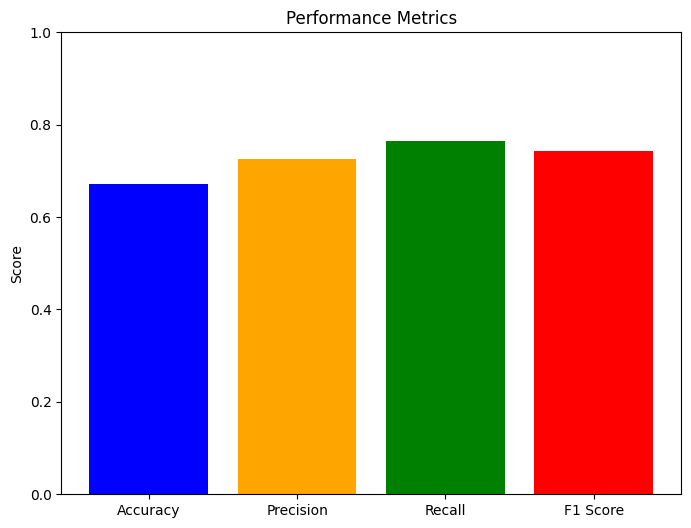

In [ ]:
# Sample metrics
metrics = {
    'Accuracy': 0.6712,
    'Precision': 0.72506,
    'Recall': 0.76410,
    'F1 Score': 0.74407
}

# Create a bar plot for performance metrics
plt.figure(figsize=(8, 6))
plt.bar(metrics.keys(), metrics.values(), color=['blue', 'orange', 'green', 'red'])
plt.ylim(0, 1)  # Set y-axis limits from 0 to 1
plt.title('Performance Metrics')
plt.ylabel('Score')
plt.show()


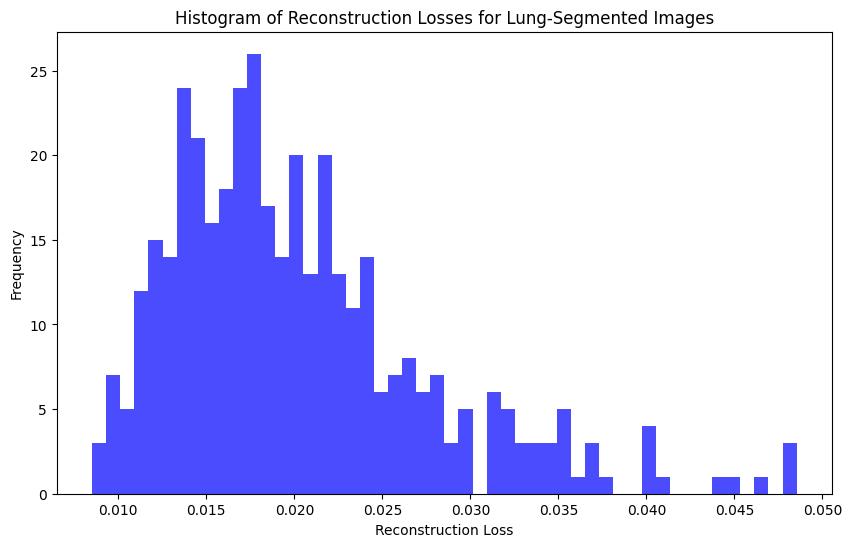

In [ ]:
import matplotlib.pyplot as plt

# Calculate reconstruction losses for each image in train_data
reconstruction_losses = []
for img in train_data:
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    reconstructed_img = vae(img)
    loss = np.mean((img - reconstructed_img) ** 2)  # MSE per image
    reconstruction_losses.append(loss)

# Convert losses to a NumPy array
reconstruction_losses = np.array(reconstruction_losses)

# Plot histogram of reconstruction losses
plt.figure(figsize=(10, 6))
plt.hist(reconstruction_losses, bins=50, color='blue', alpha=0.7)
plt.xlabel('Reconstruction Loss')
plt.ylabel('Frequency')
plt.title('Histogram of Reconstruction Losses for Lung-Segmented Images')
plt.show()


In [ ]:
!pip install Pillow

In [ ]:
from PIL import Image, ImageDraw, ImageFont

# Define the dimensions of the report
width, height = 600, 800  # Smaller dimensions for a more compact page
background_color = "white"
text_color = "black"

# Create a blank white image
image = Image.new("RGB", (width, height), background_color)
draw = ImageDraw.Draw(image)

# Try to load fonts, fallback to default if Arial is unavailable
try:
    font_title = ImageFont.truetype("/usr/share/fonts/truetype/msttcorefonts/Arial-Bold.ttf", 36)  # Bold and larger font for the title
    font_subtitle = ImageFont.truetype("/usr/share/fonts/truetype/msttcorefonts/Arial.ttf", 18)    # Smaller font for body text
except OSError:
    font_title = ImageFont.load_default()
    font_subtitle = ImageFont.load_default()

# Add the X-ray image at the top
xray_image_path = "/download (1)2.png"  # Update with your X-ray image path
xray = Image.open(xray_image_path).resize((250, 250))  # Resize to fit nicely on the report
image.paste(xray, (175, 20))  # Center the image at the top

# Add Report Title
draw.text((260, 290), "Medical Report", fill=text_color, font=font_title)

# Add Findings
findings_text = (
    "Findings:\n"
    "The X-ray reveals widespread red-shaded regions indicating significant pulmonary\n"
    "consolidation and inflammation, suggestive of moderate to severe pneumonia.\n"
    "Segmentation highlights critical areas requiring further clinical evaluation."
)
draw.text((50, 350), findings_text, fill=text_color, font=font_subtitle, spacing=4)

# Add Model Metrics
metrics_text = (
    "Model Metrics:\n"
    "Accuracy: 66.15%\n"
    "Precision: 72.5%\n"
    "Recall: 76.4%\n"
    "F1 Score: 74.4%"
)
draw.text((50, 430), metrics_text, fill=text_color, font=font_subtitle, spacing=4)

# Add Observations
observations_text = "Observations:\nPneumonia, Lung Opacity."
draw.text((50, 530), observations_text, fill=text_color, font=font_subtitle, spacing=4)

# Save and Display the Report
report_path = "/kaggle/report.png"
image.save(report_path)
image.show()

print(f"Report saved at {report_path}")


Report saved at /kaggle/report.png
